# 한강공원 주차 혼잡도 및 이용 가능 예측

### 주요 목표:
    한강공원의 주차 혼잡도를 시간대별(아침,낮,저녁)로 예측하는 모델 구축
    데이터 전처리 및 Feature Engineering을 통해 주요 변수 선택
    주요 이용 가능 확률 예측
    주차 혼잡도(여유, 보통, 혼잡, 만차)예측

### 초기 세팅

In [741]:
import warnings
warnings.filterwarnings('ignore')

In [742]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform
import matplotlib.pyplot as plt

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

---
# 한강 공원 Data 

In [ ]:
# 데이터 불러오기
import pandas as pd

# 데이터 일별 주차대수 및 이용시간 현황
df_day = pd.read_csv("../Data/한강공원 주차장 일별 이용 현황.csv", encoding='euc-kr', index_col=False)
# 데이터 월별 공원 
df_month = pd.read_csv("../Data/서울시 한강공원 월별 이용객 현황.csv", encoding='euc-kr', index_col=False)

In [744]:
# 데이터 확인하기
print(f"한강공원 주차장 일별 데이터 :")
print(df_day.info())

한강공원 주차장 일별 데이터 :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45277 entries, 0 to 45276
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지구별     45277 non-null  object
 1   주차장명    45277 non-null  object
 2   주차대수    45277 non-null  int64 
 3   이용시간    45277 non-null  int64 
 4   날짜      45277 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.7+ MB
None


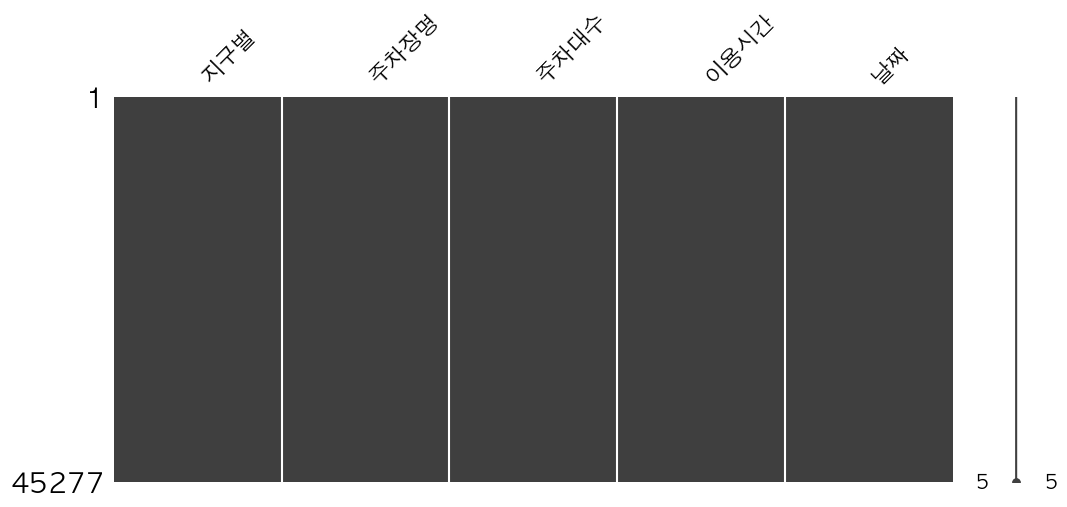

In [745]:
# 결측치 시각화
# train NaN값 시각화
import missingno as msno
import matplotlib.pyplot as plt
msno.matrix(df_day, figsize=(12, 5))

plt.show()

> 주차장 일별 데이터에는 결측치가 없음

In [746]:
# 날짜 컬럼을 날짜 형식으로 전환
df_day['날짜'] = pd.to_datetime(df_day['날짜'], format= '%Y/%m/%d')

# 일별 날짜 컬럼을 연,월,일 컬럼으로 분리
df_day['연도'] = df_day['날짜'].dt.year
df_day['월'] = df_day['날짜'].dt.month
df_day['일'] = df_day['날짜'].dt.day

df_day

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일
0,PLT-005,뚝섬1주차장,273,22891,2024-11-10,2024,11,10
1,PLT-011,잠실1주차장,1059,66361,2024-11-10,2024,11,10
2,PLT-001,강서1주차장,329,26875,2024-11-10,2024,11,10
3,PLT-008,여의도5주차장,229,22509,2024-11-10,2024,11,10
4,PLT-008,여의도2주차장,1934,150135,2024-11-10,2024,11,10
...,...,...,...,...,...,...,...,...
45272,PLT-008,여의도1주차장,873,221484,2020-01-16,2020,1,16
45273,PLT-001,강서1주차장,28,347,2020-01-16,2020,1,16
45274,PLT-008,여의도1주차장,114,6073,2020-01-15,2020,1,15
45275,PLT-001,강서1주차장,12,68,2020-01-15,2020,1,15


요일 정보 => 0:월요일 ~ 6: 일요일           
휴일여부 정보 => 0: 평일, 1: 휴일

In [747]:
# 평일 휴일로 분리 및 요일 변환 
import holidays

# 대한민국 공휴일 가져오기
kr_holidays = holidays.KR(years=range(2020,2025))

# 요일 변환
weekday_map = {0 : 0, 1 : 1, 2 : 2, 3: 3, 4: 4, 5: 5, 6: 6}

# 요일 숫자를 요일 이름으로 변환
df_day['요일'] = df_day['날짜'].dt.weekday.map(weekday_map)

# 날짜가 공휴일인지를 체크하는 함수 추가
df_day['휴일여부'] = df_day['날짜'].apply(lambda x: 2 if x in kr_holidays else (1 if x.weekday() >= 5 else 0))

# 데이터 확인
df_day

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일,요일,휴일여부
0,PLT-005,뚝섬1주차장,273,22891,2024-11-10,2024,11,10,6,1
1,PLT-011,잠실1주차장,1059,66361,2024-11-10,2024,11,10,6,1
2,PLT-001,강서1주차장,329,26875,2024-11-10,2024,11,10,6,1
3,PLT-008,여의도5주차장,229,22509,2024-11-10,2024,11,10,6,1
4,PLT-008,여의도2주차장,1934,150135,2024-11-10,2024,11,10,6,1
...,...,...,...,...,...,...,...,...,...,...
45272,PLT-008,여의도1주차장,873,221484,2020-01-16,2020,1,16,3,0
45273,PLT-001,강서1주차장,28,347,2020-01-16,2020,1,16,3,0
45274,PLT-008,여의도1주차장,114,6073,2020-01-15,2020,1,15,2,0
45275,PLT-001,강서1주차장,12,68,2020-01-15,2020,1,15,2,0


> 공공데이터의 이용시간이 누적 분을 기준으로 하기때문에 차량당 평균 주차시간을 구하기위해서 컬럼을 추가해준다.

In [748]:
# 평균 주차시간 컬럼 추가
df_day['평균_주차시간(분)'] = df_day['이용시간'] / df_day['주차대수']

### 주차장명 평균 주차시간 (분)

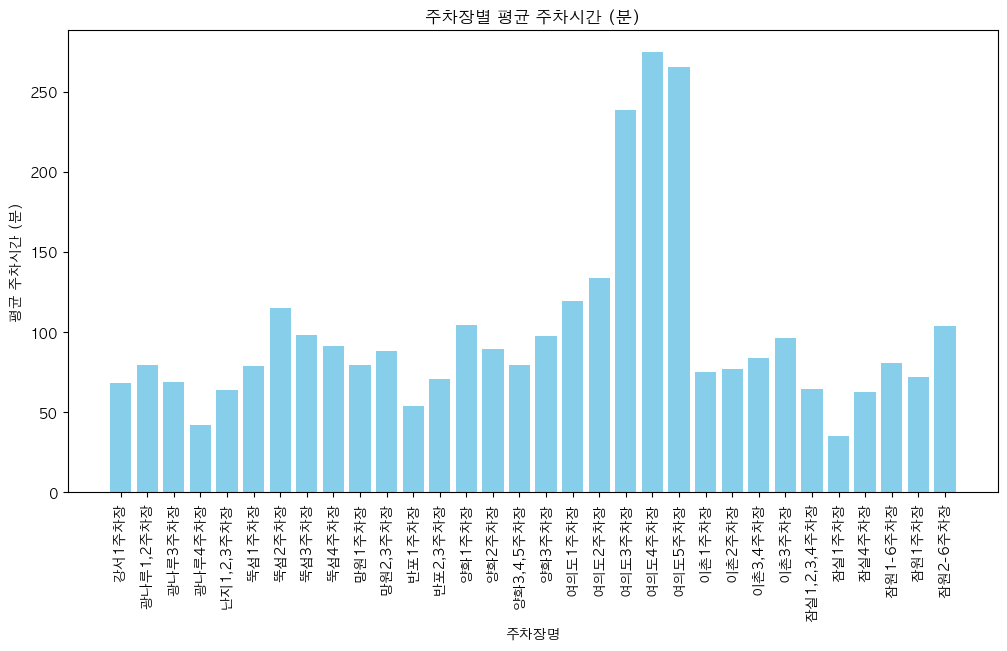

In [749]:
import matplotlib.pyplot as plt

# 주차장별 평균 주차시간을 계산
# 주차장명으로 그룹화하여 각 주차장별 총 이용시간을 주차대수로 나눠 평균을 구함
avg_parking_time = df_day.groupby('주차장명').apply(lambda x: x['이용시간'].sum() / x['주차대수'].sum())
avg_parking_time = avg_parking_time.reset_index()
avg_parking_time.columns = ['주차장명', '평균_주차시간(분)']

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(avg_parking_time['주차장명'], avg_parking_time['평균_주차시간(분)'], color='skyblue')
plt.title('주차장별 평균 주차시간 (분)')
plt.xlabel('주차장명')
plt.ylabel('평균 주차시간 (분)')
plt.xticks(rotation=90)
plt.show()


> 여의도의 평균 주차시간이 많은 것으로 보인다. 4시간 가까이 되는 시간이 많기 때문에 정기주차의 이상치도 들어간 것으로 추측됨

### 날씨 
- 한강공원은 날씨 평균기온에 따라 인구수 차이가 있는 기사를 확인해서 데이터를 추가


In [752]:
df_day[df_day['지구별'] == 'PLT-008']

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일,요일,휴일여부,평균_주차시간(분)
3,PLT-008,여의도5주차장,229,22509,2024-11-10,2024,11,10,6,1,98.292576
4,PLT-008,여의도2주차장,1934,150135,2024-11-10,2024,11,10,6,1,77.629266
9,PLT-008,여의도1주차장,3398,355119,2024-11-10,2024,11,10,6,1,104.508240
19,PLT-008,여의도4주차장,41,1994,2024-11-10,2024,11,10,6,1,48.634146
24,PLT-008,여의도3주차장,2326,318649,2024-11-10,2024,11,10,6,1,136.994411
...,...,...,...,...,...,...,...,...,...,...,...
45261,PLT-008,여의도1주차장,1541,172802,2020-01-18,2020,1,18,5,1,112.136275
45267,PLT-008,여의도1주차장,1113,255747,2020-01-17,2020,1,17,4,0,229.781671
45272,PLT-008,여의도1주차장,873,221484,2020-01-16,2020,1,16,3,0,253.704467
45274,PLT-008,여의도1주차장,114,6073,2020-01-15,2020,1,15,2,0,53.271930


In [759]:
df_day[df_day['지구별'] == 'PLT-005']

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일,요일,휴일여부,평균_주차시간(분)
0,PLT-005,뚝섬1주차장,273,22891,2024-11-10,2024,11,10,6,1,83.849817
10,PLT-005,뚝섬3주차장,686,62848,2024-11-10,2024,11,10,6,1,91.615160
16,PLT-005,뚝섬4주차장,864,79419,2024-11-10,2024,11,10,6,1,91.920139
21,PLT-005,뚝섬2주차장,965,108345,2024-11-10,2024,11,10,6,1,112.274611
30,PLT-005,뚝섬2주차장,850,91910,2024-11-09,2024,11,9,5,1,108.129412
...,...,...,...,...,...,...,...,...,...,...,...
45232,PLT-005,뚝섬2주차장,127,30987,2020-01-21,2020,1,21,1,0,243.992126
45255,PLT-005,뚝섬3주차장,58,1468,2020-01-20,2020,1,20,0,0,25.310345
45259,PLT-005,뚝섬3주차장,242,14229,2020-01-19,2020,1,19,6,1,58.797521
45265,PLT-005,뚝섬3주차장,253,18191,2020-01-18,2020,1,18,5,1,71.901186


In [697]:
# 날씨 CSV FILE 불러오기
weather_seoul = pd.read_csv("../Data/서울날씨20-24.csv", encoding='euc-kr')

# Data 확인하기
weather_seoul.sort_values(by='일시', axis=0,ascending=False, inplace=True)
weather_seoul

,지점,지점명,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),일강수량(mm),평균 이슬점온도(°C),평균 상대습도(%)
1762,108,서울,2024-11-10,14.4,10.3,536.0,21.0,1520,NaN,NaN,7.4,64.0
1761,108,서울,2024-11-09,12.9,6.8,607.0,20.3,1436,NaN,NaN,3.9,55.8
1760,108,서울,2024-11-08,10.2,3.1,629.0,18.1,1501,NaN,NaN,0.1,50.8
1759,108,서울,2024-11-07,7.8,1.6,707.0,15.7,1515,NaN,NaN,-3.0,48.1
1758,108,서울,2024-11-06,7.5,4.1,628.0,12.5,1430,NaN,NaN,-3.6,46.1
...,...,...,...,...,...,...,...,...,...,...,...,...
4,108,서울,2020-01-18,0.3,-4.1,802.0,5.9,1503,NaN,NaN,-10.0,48.1
3,108,서울,2020-01-17,-0.6,-4.8,720.0,4.9,1449,NaN,NaN,-11.7,43.9
2,108,서울,2020-01-16,-1.7,-5.5,816.0,3.2,1430,NaN,NaN,-13.0,43.0
1,108,서울,2020-01-15,-2.7,-6.4,722.0,2.2,1510,NaN,NaN,-13.4,44.8


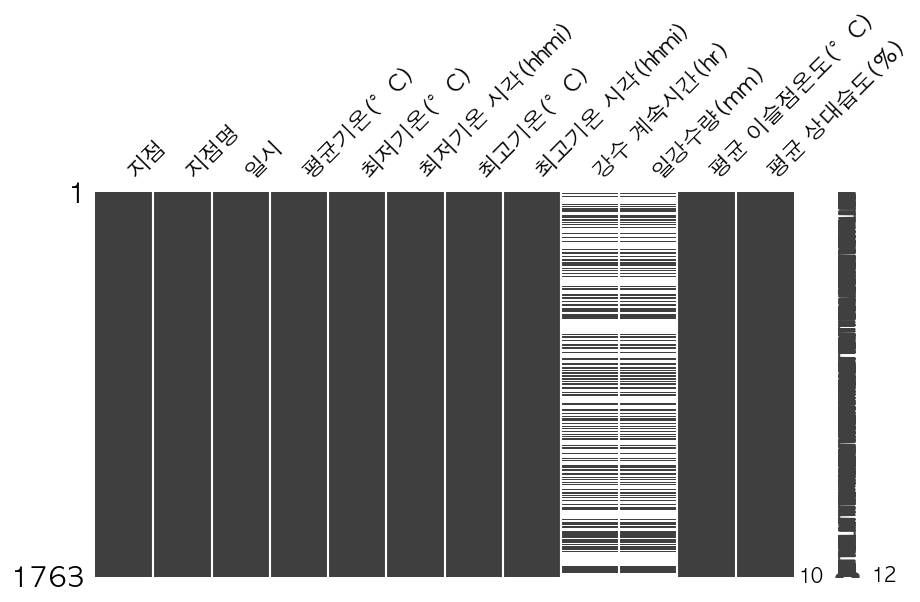

In [698]:
# 결측치 확인하기

msno.matrix(weather_seoul, figsize=(10,5))
plt.show()

> 강수 계속시간과 일 강수량은 결측치가 많은 것으로 확인된다.        
결측치가 많은 이유는 비가 오지 않은 날을 기입을 하지 않은 것으로 보임.

In [699]:
# 일시 컬럼 날짜 컬럼명 KEY 값 연동
weather_seoul['날짜'] = weather_seoul['일시']

# 데이터 변환
weather_seoul['날짜'] = pd.to_datetime(weather_seoul['날짜'], format='%Y-%m-%d')

# 날짜를 기준으로 병합
df_merged = pd.merge(df_day, weather_seoul[['날짜', '평균기온(°C)']],
                     how='left', left_on='날짜', right_on='날짜')

# 병합 결과 확인
df_merged

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일,요일,휴일여부,평균_주차시간(분),평균기온(°C)
0,PLT-005,뚝섬1주차장,273,22891,2024-11-10,2024,11,10,6,1,83.849817,14.4
1,PLT-011,잠실1주차장,1059,66361,2024-11-10,2024,11,10,6,1,62.663834,14.4
2,PLT-001,강서1주차장,329,26875,2024-11-10,2024,11,10,6,1,81.686930,14.4
3,PLT-008,여의도5주차장,229,22509,2024-11-10,2024,11,10,6,1,98.292576,14.4
4,PLT-008,여의도2주차장,1934,150135,2024-11-10,2024,11,10,6,1,77.629266,14.4
...,...,...,...,...,...,...,...,...,...,...,...,...
45272,PLT-008,여의도1주차장,873,221484,2020-01-16,2020,1,16,3,0,253.704467,-1.7
45273,PLT-001,강서1주차장,28,347,2020-01-16,2020,1,16,3,0,12.392857,-1.7
45274,PLT-008,여의도1주차장,114,6073,2020-01-15,2020,1,15,2,0,53.271930,-2.7
45275,PLT-001,강서1주차장,12,68,2020-01-15,2020,1,15,2,0,5.666667,-2.7


### 한강공원 월별 이용객 데이터 불러오기
- 한강공원에 일별 주차 비율(혼잡도)을 예측하기 위해서는 데이터가 부족           
- 월별 데이터를 이용하여 이용자의 '아침', '낮', '저녁'의 비율을 파악        
- 파악한 이유는 비율로 주차장의 데이터를 군집회하기 위함.       

In [700]:
df_month = pd.read_csv("../Data/서울시 한강공원 월별 이용객 현황.csv", encoding='euc-kr')
df_month

,현황 일련번호,공원 코드,공원명,공원 시명,공원 구명,공원 지번 주소,공원 도로명 주소,등록자 일련번호,등록 일시,수정자 일련번호,...,강변물놀이장,강변프롬나드,난지 하늘다리,갈대숲탐장로,꿀벌숲,치유의숲,그라스정원,노들섬,습지생태공원,현황 일시
0,87623,Hzone001,광나루한강공원,서울,강동구,암사동 637-6,선사로 83-106,83,2024-03-08 10:40:48.0,NaN,...,0,0,0,0,0,0,0,0,0,2024-02-29 00:00:00.0
1,87629,Hzone006,이촌한강공원,서울,용산구,이촌동 302-17,이촌로72길 62,83,2024-03-08 14:14:33.0,NaN,...,0,0,0,0,0,0,0,19198,0,2024-02-29 00:00:00.0
2,87626,Hzone003,뚝섬한강공원,서울,광진구,자양동 427-1,강변북로 2273,83,2024-03-08 11:29:41.0,83.0,...,0,0,0,0,0,0,0,0,0,2024-02-29 00:00:00.0
3,87625,Hzone002,잠실한강공원,서울,송파구,잠실동 1-1,한가람로 65,83,2024-03-08 10:44:40.0,NaN,...,0,0,0,0,0,0,0,0,0,2024-02-29 00:00:00.0
4,87631,Hzone008,양화한강공원,서울,영등포구,당산동 98-1,노들로 221,83,2024-03-08 14:40:51.0,NaN,...,0,0,0,0,0,0,0,0,0,2024-02-29 00:00:00.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,86798,Hzone002,잠실한강공원,서울,송파구,잠실동 1-1,한가람로 65,5,2018-01-31 00:00:00.0,NaN,...,0,0,0,0,0,0,0,0,0,2018-01-31 00:00:00.0
811,86802,Hzone007,여의도한강공원,서울,영등포구,여의도동 85-1,여의동로 280,10,2018-01-31 00:00:00.0,NaN,...,0,0,0,0,0,0,0,0,0,2018-01-31 00:00:00.0
812,86801,Hzone008,양화한강공원,서울,영등포구,당산동 98-1,노들로 221,11,2018-01-31 00:00:00.0,NaN,...,0,0,0,0,0,0,0,0,0,2018-01-31 00:00:00.0
813,86800,Hzone003,뚝섬한강공원,서울,광진구,자양동 427-1,강변북로 2273,6,2018-01-31 00:00:00.0,NaN,...,0,0,0,0,0,0,0,0,0,2018-01-31 00:00:00.0


In [701]:
# 현황 일시가 object type을 datetime으로 변환
df_month['현황 일시'] = pd.to_datetime(df_month['현황 일시'], format='%Y-%m-%d %H:%M:%S.%f')

# 일별 날짜 컬럼을 연도, 월 컬럼으로 분리
df_month['연도'] = df_month['현황 일시'].dt.year
df_month['월'] = df_month['현황 일시'].dt.month

# 데이터 info확인
df_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 64 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   현황 일련번호      815 non-null    int64         
 1   공원 코드        815 non-null    object        
 2   공원명          815 non-null    object        
 3   공원 시명        815 non-null    object        
 4   공원 구명        815 non-null    object        
 5   공원 지번 주소     815 non-null    object        
 6   공원 도로명 주소    815 non-null    object        
 7   등록자 일련번호     815 non-null    int64         
 8   등록 일시        815 non-null    object        
 9   수정자 일련번호     62 non-null     float64       
 10  수정 일시        62 non-null     object        
 11  일반이용자(아침)    812 non-null    float64       
 12  일반이용자(낮)     815 non-null    int64         
 13  일반이용자(저녁)    815 non-null    int64         
 14  자전거          815 non-null    int64         
 15  인라인          810 non-null    float64       
 16  pm(개인형이동

> 사용하려는 데이터 일반이용자(아침)이 null값이 3개 존재함.

In [702]:
# 3개이므로 null값을 평균대치법 사용.

# NaN 값을 평균값으로 채운 후 int로 변환
df_month['일반이용자(아침)'] = df_month['일반이용자(아침)'].fillna(df_month['일반이용자(아침)'].mean()).astype('int')

# 2020년 1월 14일부터 2024년 2월 29일까지의 데이터 추출
start_date = '2020-01-14'
end_date = '2024-02-29'
filtered_df = df_month[df_month['현황 일시'].between(start_date, end_date)]
filtered_df = filtered_df.loc[:,['공원 코드','연도', '월','일반이용자(아침)','일반이용자(낮)','일반이용자(저녁)']]
print(filtered_df)

        공원 코드    연도  월  일반이용자(아침)  일반이용자(낮)  일반이용자(저녁)
0    Hzone001  2024  2       2840     33780      25450
1    Hzone006  2024  2       5145     47990      37857
2    Hzone003  2024  2      13100    167450     187420
3    Hzone002  2024  2       9820     41340      49010
4    Hzone008  2024  2      11150     33940      32050
..        ...   ... ..        ...       ...        ...
546  Hzone010  2020  1       2854     50209      41380
547  Hzone003  2020  1     115350    426960     244710
548  Hzone009  2020  1       3855     35250      32910
549  Hzone001  2020  1      11110     47790      37360
550  Hzone011  2020  1       4515     42401      36832

[551 rows x 6 columns]


In [703]:
# 일별 데이터에 merge하기 위해 공원코드 지구별 코드로 변환

park_code = {'Hzone011' : 'PLT-001', 'Hzone009' : 'PLT-002', 'Hzone010' : 'PLT-003', 'Hzone006' : 'PLT-004', 'Hzone003' : 'PLT-005', 'Hzone001' : 'PLT-006', 'Hzone008' : 'PLT-007', 'Hzone007' : 'PLT-008', 'Hzone005' : 'PLT-009', 'Hzone004' : 'PLT-0010', 'Hzone002' : 'PLT-0011'}

filtered_df['공원 코드'] = filtered_df['공원 코드'].map(park_code)

filtered_df.rename(columns={'공원 코드':'지구별'}, inplace=True)

In [704]:
# 일별 데이터와 merge
df = pd.merge(df_merged, filtered_df, how='left', left_on=['지구별','연도','월'], right_on=['지구별','연도','월'])

In [705]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45277 entries, 0 to 45276
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   지구별         45277 non-null  object        
 1   주차장명        45277 non-null  object        
 2   주차대수        45277 non-null  int64         
 3   이용시간        45277 non-null  int64         
 4   날짜          45277 non-null  datetime64[ns]
 5   연도          45277 non-null  int32         
 6   월           45277 non-null  int32         
 7   일           45277 non-null  int32         
 8   요일          45277 non-null  int64         
 9   휴일여부        45277 non-null  int64         
 10  평균_주차시간(분)  45277 non-null  float64       
 11  평균기온(°C)    45277 non-null  float64       
 12  일반이용자(아침)   34132 non-null  float64       
 13  일반이용자(낮)    34132 non-null  float64       
 14  일반이용자(저녁)   34132 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int32(3), int64(4), object(2)
memory

> 데이터가 2024 2월 까지 밖에 없었으므로 3월부터11월 까지는 월별 일반 이용자수가 결측치로 처리되는 것을 확인 할 수 있다.

### 일반이용자 아침 낮 저녁 비율 확인

In [706]:
df['일반이용자 합계']= df['일반이용자(아침)'] + df['일반이용자(낮)'] + df['일반이용자(저녁)']

person_ratio0 = round((df['일반이용자(아침)'] / df['일반이용자 합계'] * 100).mean(), 2)
person_ratio1 = round((df['일반이용자(낮)'] / df['일반이용자 합계'] * 100).mean(), 2)
person_ratio2 = round((df['일반이용자(저녁)'] / df['일반이용자 합계'] * 100).mean(), 2)

person_ratio = pd.DataFrame(
    columns=['아침', '낮', '저녁'],
    data= [[person_ratio0,
           person_ratio1,
           person_ratio2
           ]]
)

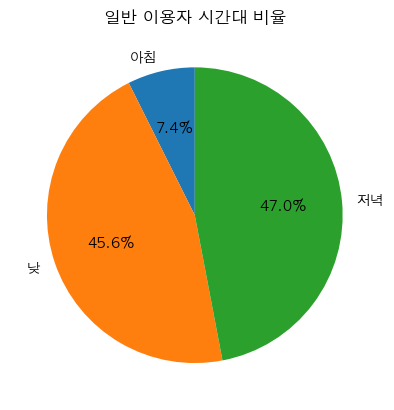

In [707]:
import matplotlib.pyplot as plt

# person_ratio의 각 시간대 비율을 추출
person_ratio_values = person_ratio.iloc[0] 

# pie chart
plt.pie(person_ratio_values, labels=person_ratio.columns, autopct='%1.1f%%', startangle=90)

# 그래프 출력
plt.title('일반 이용자 시간대 비율')
plt.show()

> 월별 데이터인 일반 이용자 시간대 비율이 저녁과 낮은 비슷하고 아침이 가장 낮은것으로 파악할 수 있다.

### 한강 월평균 2024년 03월~09월 데이터 불러오기

In [708]:
df_2024 = pd.read_csv("../Data/한강2403-2409.csv")
# data info 
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   전체 이용객   77 non-null     object
 1   일평균 이용객  77 non-null     object
 2   현지인 이용객  77 non-null     object
 3   외지인 이용객  77 non-null     object
 4   외국인 이용객  77 non-null     object
 5   자전거 이용객  77 non-null     object
 6   선호 연령대   77 non-null     object
 7   선호 시간대   77 non-null     object
 8   지점       77 non-null     object
dtypes: object(9)
memory usage: 5.5+ KB


In [709]:
# 지점을 지점코드로 변경

park_code = {'강서' : 'PLT-001', '난지' : 'PLT-002', '망원' : 'PLT-003', '이촌' : 'PLT-004', '뚝섬' : 'PLT-005', '광나루' : 'PLT-006', '양화' : 'PLT-007', '여의도' : 'PLT-008', '반포' : 'PLT-009', '잠원' : 'PLT-010', '잠실' : 'PLT-011'}

df_2024['지점'] = df_2024['지점'].map(park_code)

# 월별 데이터 그룹화
month_groups = []
months = ['3', '4', '5', '6', '7', '8', '9']
num_rows_per_month = 11  # 월별로 나누는 행의 수

for i, month in enumerate(months):
    start_idx = i * num_rows_per_month
    end_idx = start_idx + num_rows_per_month
    month_group = df_2024.iloc[start_idx:end_idx].copy()
    month_group['월'] = month  # 각 그룹에 해당 월 정보를 추가
    month_groups.append(month_group)

# 월별 데이터프레임 합치기
df_2024 = pd.concat(month_groups, ignore_index=True)

# 연도 컬럼 추가
df_2024['연도'] = 2024

In [710]:
# 일반이용자수 계산을 위하여 데이터 변환
# regex 정규표현식 이용 
df_2024['전체 이용객'] = df_2024['전체 이용객'].replace({',':''}, regex=True).astype('int')

# 월이 원본데이터에는 int type이므로 object type을 변환
df_2024['월'] = df_2024['월'].astype('int')

# 월별로 일반이용자수(아침) , 일반이용자수(낮), 일반이용자수(저녁)으로 분리
# 곱해주는 수는 위의 시간대 비율을 이용해 곱해준다.
df_2024['일반이용자(아침)'] = round(df_2024['전체 이용객'] * 0.074)
df_2024['일반이용자(낮)'] = round(df_2024['전체 이용객'] * 0.456)
df_2024['일반이용자(저녁)'] = round(df_2024['전체 이용객'] * 0.47)

df_2024.rename(columns={'지점':'지구별'}, inplace=True)
df_2024 = df_2024.loc[:,['지구별','월','연도','일반이용자(아침)','일반이용자(낮)','일반이용자(저녁)']]

# 일별 데이터와 merge
df = pd.merge(df, df_2024, how='left', left_on=['지구별','연도','월'], right_on=['지구별','연도','월'])

In [711]:
df

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일,요일,휴일여부,평균_주차시간(분),평균기온(°C),일반이용자(아침)_x,일반이용자(낮)_x,일반이용자(저녁)_x,일반이용자 합계,일반이용자(아침)_y,일반이용자(낮)_y,일반이용자(저녁)_y
0,PLT-005,뚝섬1주차장,273,22891,2024-11-10,2024,11,10,6,1,83.849817,14.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PLT-011,잠실1주차장,1059,66361,2024-11-10,2024,11,10,6,1,62.663834,14.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PLT-001,강서1주차장,329,26875,2024-11-10,2024,11,10,6,1,81.686930,14.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PLT-008,여의도5주차장,229,22509,2024-11-10,2024,11,10,6,1,98.292576,14.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PLT-008,여의도2주차장,1934,150135,2024-11-10,2024,11,10,6,1,77.629266,14.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45272,PLT-008,여의도1주차장,873,221484,2020-01-16,2020,1,16,3,0,253.704467,-1.7,7145.0,37903.0,31569.0,76617.0,NaN,NaN,NaN
45273,PLT-001,강서1주차장,28,347,2020-01-16,2020,1,16,3,0,12.392857,-1.7,4515.0,42401.0,36832.0,83748.0,NaN,NaN,NaN
45274,PLT-008,여의도1주차장,114,6073,2020-01-15,2020,1,15,2,0,53.271930,-2.7,7145.0,37903.0,31569.0,76617.0,NaN,NaN,NaN
45275,PLT-001,강서1주차장,12,68,2020-01-15,2020,1,15,2,0,5.666667,-2.7,4515.0,42401.0,36832.0,83748.0,NaN,NaN,NaN


In [712]:
# '일반이용자(아침)_x'와 '일반이용자(아침)_y' 합치기
df['일반이용자(아침)'] = df['일반이용자(아침)_x'].fillna(df['일반이용자(아침)_y'])

# '일반이용자(낮)_x'와 '일반이용자(낮)_y' 합치기
df['일반이용자(낮)'] = df['일반이용자(낮)_x'].fillna(df['일반이용자(낮)_y'])

# '일반이용자(저녁)_x'와 '일반이용자(저녁)_y' 합치기
df['일반이용자(저녁)'] = df['일반이용자(저녁)_x'].fillna(df['일반이용자(저녁)_y'])

# 필요 없는 컬럼 삭제
df.drop(columns=['일반이용자(아침)_x', '일반이용자(아침)_y', 
                 '일반이용자(낮)_x', '일반이용자(낮)_y', 
                 '일반이용자(저녁)_x', '일반이용자(저녁)_y'], inplace=True)

df['일반이용자 합계'] = df['일반이용자(아침)'] + df['일반이용자(낮)'] + df['일반이용자(저녁)']

In [713]:
df

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일,요일,휴일여부,평균_주차시간(분),평균기온(°C),일반이용자 합계,일반이용자(아침),일반이용자(낮),일반이용자(저녁)
0,PLT-005,뚝섬1주차장,273,22891,2024-11-10,2024,11,10,6,1,83.849817,14.4,NaN,NaN,NaN,NaN
1,PLT-011,잠실1주차장,1059,66361,2024-11-10,2024,11,10,6,1,62.663834,14.4,NaN,NaN,NaN,NaN
2,PLT-001,강서1주차장,329,26875,2024-11-10,2024,11,10,6,1,81.686930,14.4,NaN,NaN,NaN,NaN
3,PLT-008,여의도5주차장,229,22509,2024-11-10,2024,11,10,6,1,98.292576,14.4,NaN,NaN,NaN,NaN
4,PLT-008,여의도2주차장,1934,150135,2024-11-10,2024,11,10,6,1,77.629266,14.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45272,PLT-008,여의도1주차장,873,221484,2020-01-16,2020,1,16,3,0,253.704467,-1.7,76617.0,7145.0,37903.0,31569.0
45273,PLT-001,강서1주차장,28,347,2020-01-16,2020,1,16,3,0,12.392857,-1.7,83748.0,4515.0,42401.0,36832.0
45274,PLT-008,여의도1주차장,114,6073,2020-01-15,2020,1,15,2,0,53.271930,-2.7,76617.0,7145.0,37903.0,31569.0
45275,PLT-001,강서1주차장,12,68,2020-01-15,2020,1,15,2,0,5.666667,-2.7,83748.0,4515.0,42401.0,36832.0


### 월별 평균으로 10월~11월 NaN 값 처리하기

In [714]:
# NaN이 포함된 컬럼들을 확인
df[['일반이용자 합계', '일반이용자(아침)', '일반이용자(낮)', '일반이용자(저녁)']].isna().sum()

일반이용자 합계     5211
일반이용자(아침)    5211
일반이용자(낮)     5211
일반이용자(저녁)    5211
dtype: int64

In [715]:
df

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일,요일,휴일여부,평균_주차시간(분),평균기온(°C),일반이용자 합계,일반이용자(아침),일반이용자(낮),일반이용자(저녁)
0,PLT-005,뚝섬1주차장,273,22891,2024-11-10,2024,11,10,6,1,83.849817,14.4,NaN,NaN,NaN,NaN
1,PLT-011,잠실1주차장,1059,66361,2024-11-10,2024,11,10,6,1,62.663834,14.4,NaN,NaN,NaN,NaN
2,PLT-001,강서1주차장,329,26875,2024-11-10,2024,11,10,6,1,81.686930,14.4,NaN,NaN,NaN,NaN
3,PLT-008,여의도5주차장,229,22509,2024-11-10,2024,11,10,6,1,98.292576,14.4,NaN,NaN,NaN,NaN
4,PLT-008,여의도2주차장,1934,150135,2024-11-10,2024,11,10,6,1,77.629266,14.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45272,PLT-008,여의도1주차장,873,221484,2020-01-16,2020,1,16,3,0,253.704467,-1.7,76617.0,7145.0,37903.0,31569.0
45273,PLT-001,강서1주차장,28,347,2020-01-16,2020,1,16,3,0,12.392857,-1.7,83748.0,4515.0,42401.0,36832.0
45274,PLT-008,여의도1주차장,114,6073,2020-01-15,2020,1,15,2,0,53.271930,-2.7,76617.0,7145.0,37903.0,31569.0
45275,PLT-001,강서1주차장,12,68,2020-01-15,2020,1,15,2,0,5.666667,-2.7,83748.0,4515.0,42401.0,36832.0


In [716]:
# 1. 월별 평균 계산 (지구별, 월 기준)
monthly_mean = df.groupby(['지구별', '월'])[['일반이용자 합계', '일반이용자(아침)', '일반이용자(낮)', '일반이용자(저녁)']].transform('mean')

# 2. 월별 평균을 사용하여 NaN 채우기
df[['일반이용자 합계', '일반이용자(아침)', '일반이용자(낮)', '일반이용자(저녁)']] = df[['일반이용자 합계', '일반이용자(아침)', '일반이용자(낮)', '일반이용자(저녁)']].combine_first(monthly_mean)

# 3. 지구별 평균으로 남아있는 NaN 값 채우기
geo_mean = df.groupby('지구별')[['일반이용자 합계', '일반이용자(아침)', '일반이용자(낮)', '일반이용자(저녁)']].transform('mean')
df[['일반이용자 합계', '일반이용자(아침)', '일반이용자(낮)', '일반이용자(저녁)']] = df[['일반이용자 합계', '일반이용자(아침)', '일반이용자(낮)', '일반이용자(저녁)']].combine_first(geo_mean)

# 4. 전체 평균으로 남은 NaN 값 채우기
df[['일반이용자 합계', '일반이용자(아침)', '일반이용자(낮)', '일반이용자(저녁)']] = df[['일반이용자 합계', '일반이용자(아침)', '일반이용자(낮)', '일반이용자(저녁)']].fillna(df[['일반이용자 합계', '일반이용자(아침)', '일반이용자(낮)', '일반이용자(저녁)']].mean())

# 확인
print(df[['일반이용자 합계', '일반이용자(아침)', '일반이용자(낮)', '일반이용자(저녁)']].isnull().sum())

일반이용자 합계     0
일반이용자(아침)    0
일반이용자(낮)     0
일반이용자(저녁)    0
dtype: int64


In [717]:
# 이용자 수가 float type이므로 int type으로 변환시켜준다.

df[['일반이용자 합계', '일반이용자(아침)', '일반이용자(낮)', '일반이용자(저녁)']].astype('int')

,일반이용자 합계,일반이용자(아침),일반이용자(낮),일반이용자(저녁)
0,415193,30178,187465,197549
1,693833,51343,316387,326101
2,74048,6538,35767,31743
3,105621,6796,43542,55282
4,105621,6796,43542,55282
...,...,...,...,...
45272,76617,7145,37903,31569
45273,83748,4515,42401,36832
45274,76617,7145,37903,31569
45275,83748,4515,42401,36832


In [718]:
# 휴일여부를 평일 주말로 변경 => 휴일또한 주말로 처리
df['휴일여부'].replace({2:1}, inplace=True)

### 일반이용자 평일,휴일 분리

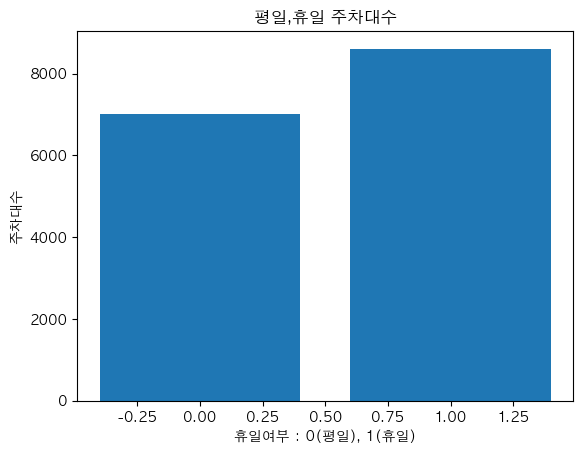

In [719]:
import matplotlib.pyplot as plt

plt.bar(
    df['휴일여부'],
    df['주차대수'],
)

plt.title('평일,휴일 주차대수')
plt.xlabel(xlabel='휴일여부 : 0(평일), 1(휴일)')
plt.ylabel(ylabel='주차대수')

plt.show()

> 평일의 주차대수 평균은 810대이고, 주말은 1183대로 차이가 있다.

> 주차장의 혼잡도를 계산할 때 일별 주차대수와 평균 주차대수를 비교하여 혼잡 여부를 판별할 수 있음.

In [720]:
# 각 주차장별 주차대수 평균 계산
# 지구별, 주차장별로 주차대수가 다르고 휴일여부에 따라 누적주차대수가 다름
# 그러므로 지구별, 주차장명, 휴일여부를 그룹으로 묶어서 주차대수의 평균을 내는 것이 적합하다고 판단하였습니다.

df['주차대수_평균'] = df.groupby(['지구별', '주차장명','휴일여부'])['주차대수'].transform('mean')

### 정리

- 현재 데이터에서 **주차대수**가 일별 누적 주차대수이므로, 하루 동안 누적된 주차대수를 의미한다.          
- 시간대별 점유율이나 혼잡도를 계산하는 데는 적합하지 않다고 판단합니다.              
- 시간대별 혼잡도를 추정하기 위해서는, 주차장 이용 패턴할 수 있는 추가적인 정보나 가정이 필요하지만,          
- 데이터를 찾아보려 했으나, 적절한 데이터가 없습니다. 
- 그러므로 현제 데이터에 있는 아침,낮,저녁 시간대별 일반 이용자 수가 포함되어 있기 때문에, 이를 이용해 시간대별로 혼잡도를 추정하는 방법을 사용하겠습니다.        
---

### 시간대별 비율로 나누기
- 일별 누적 주차대수를 시간대별 이용자 수 비율에 따라 나눠서 각 시간대의 주차대수를 추정.         
    $주차대수 * (일반이용자(아침,낮,저녁) / 일반이용자 합계)$
- 시간대별 일반 이용자 비율을 곱하여 아침,낮,저녁 시간대의 주차대수를 추정.

---
### 주차장별 총 주차 가능 대수 추가

In [721]:
# 주차장별 총 주차 가능 대수
total_parking_capacity = {
    '강서1주차장': 53,
    '광나루1,2주차장': 168,
    '광나루3주차장': 191,
    '난지1,2,3주차장': 544,
    '뚝섬1주차장': 67,
    '뚝섬2주차장': 356,
    '뚝섬3주차장': 112,
    '뚝섬4주차장': 136,
    '망원1주차장': 229,
    '반포1주차장': 332,
    '반포2,3주차장': 361,
    '양화1주차장': 88,
    '양화2주차장': 20,
    '양화3주차장': 393,
    '여의도1주차장': 462,
    '여의도2주차장': 171,
    '여의도3주차장': 800,
    '이촌3,4주차장': 257,
    '잠실1,2,3,4주차장': 471,
    '잠원1-6주차장': 735
}

# '주차장명'을 기준으로 '총_주차가능_대수' 컬럼 추가
df['총_주차가능_대수'] = df['주차장명'].map(total_parking_capacity)

# 확인
df[['주차장명', '총_주차가능_대수']].head()

,주차장명,총_주차가능_대수
0,뚝섬1주차장,67.0
1,잠실1주차장,NaN
2,강서1주차장,53.0
3,여의도5주차장,NaN
4,여의도2주차장,171.0


In [722]:
# 모델링을 하기위해서는 지구별과 주차장명을 int로 type 변환을 해줘야한다.
from sklearn.preprocessing import LabelEncoder

# 지구별, 주차장명 변환을 위한 LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 지구별과 주차장명을 정수형으로 변환
df['지구별'] = label_encoder.fit_transform(df['지구별'])
df['주차장명'] = label_encoder.fit_transform(df['주차장명'])

# 실시간 데이터에 없는 주차장명 값들을 제거합니다.
duplicate_values = [3, 10, 15, 20, 21, 22, 23, 25, 27, 28, 30, 31]
df = df[~df['주차장명'].isin(duplicate_values)]

# 결과 확인
df.reset_index(drop=True, inplace=True)
df

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일,요일,휴일여부,평균_주차시간(분),평균기온(°C),일반이용자 합계,일반이용자(아침),일반이용자(낮),일반이용자(저녁),주차대수_평균,총_주차가능_대수
0,4,5,273,22891,2024-11-10,2024,11,10,6,1,83.849817,14.4,415193.396226,30178.301887,187465.72327,197549.371069,360.992806,67.0
1,0,0,329,26875,2024-11-10,2024,11,10,6,1,81.686930,14.4,74048.750000,6538.000000,35767.25000,31743.500000,322.439338,53.0
2,7,18,1934,150135,2024-11-10,2024,11,10,6,1,77.629266,14.4,105621.500000,6796.250000,43542.50000,55282.750000,1451.985689,171.0
3,6,13,384,31676,2024-11-10,2024,11,10,6,1,82.489583,14.4,119911.250000,2432.500000,59394.00000,58084.750000,335.400359,88.0
4,6,14,88,10081,2024-11-10,2024,11,10,6,1,114.556818,14.4,119911.250000,2432.500000,59394.00000,58084.750000,87.289568,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31386,7,17,873,221484,2020-01-16,2020,1,16,3,0,253.704467,-1.7,76617.000000,7145.000000,37903.00000,31569.000000,1936.606571,462.0
31387,0,0,28,347,2020-01-16,2020,1,16,3,0,12.392857,-1.7,83748.000000,4515.000000,42401.00000,36832.000000,169.957045,53.0
31388,7,17,114,6073,2020-01-15,2020,1,15,2,0,53.271930,-2.7,76617.000000,7145.000000,37903.00000,31569.000000,1936.606571,462.0
31389,0,0,12,68,2020-01-15,2020,1,15,2,0,5.666667,-2.7,83748.000000,4515.000000,42401.00000,36832.000000,169.957045,53.0


In [723]:
# 월별데이터인 일반 이용자를 평일/휴일 기준으로 일별 분배
# 월별데이터가 1~31일까지가 아니라 평일수와 휴일수를 추출해야함.

df['평일수'] = df.groupby(['연도','월','지구별','주차장명'])['휴일여부'].transform(lambda x: (x==0).sum())
df['휴일수'] = df.groupby(['연도','월','지구별','주차장명'])['휴일여부'].transform(lambda x: (x==1).sum())

In [724]:
# 일별로 일반이용자 데이터를 분배

def distribution(row, column_name, 평일수_column='평일수', 휴일수_column='휴일수'):
    if row['휴일여부'] == 1:  # 휴일인 경우
        return row[column_name] / row[휴일수_column]
    else:  # 평일인 경우
        return row[column_name] / row[평일수_column]

df['일반이용자_합계_일별'] = df.apply(lambda row: distribution(row, '일반이용자 합계'), axis=1)
df['일반이용자_아침_일별'] = df.apply(lambda row: distribution(row, '일반이용자(아침)'), axis=1)
df['일반이용자_낮_일별'] = df.apply(lambda row: distribution(row, '일반이용자(낮)'), axis=1)
df['일반이용자_저녁_일별'] = df.apply(lambda row: distribution(row, '일반이용자(저녁)'), axis=1)

In [725]:
# 주차대수 조건별 평균을 평일, 휴일 기준으로 일별로 변환
df['주차대수_평균'] = df.apply(
    lambda row: row['주차대수_평균'] / row['평일수'] if row['휴일여부'] == 0 
    else row['주차대수_평균'] / row['휴일수'], axis=1)

# 주차 가능 확률 계산을 위해 사용 가능한 주차대수를 기준으로 점유율 계산
df['주차 가능 확률'] = (df['총_주차가능_대수'] / df['주차대수_평균']).apply(lambda x: min(x, 1))

> 평일과 휴일 차이뿐 아니라, 각 주차장의 평균 수용 능력을 반영하여 혼잡도를 예측하기위함.

In [727]:
# 시간대별 주차대수 계산
df['주차대수_아침'] = df['주차대수'] * (df['일반이용자_아침_일별'] / df['일반이용자_합계_일별'])
df['주차대수_낮'] = df['주차대수'] * (df['일반이용자_낮_일별'] / df['일반이용자_합계_일별'])
df['주차대수_저녁'] = df['주차대수'] * (df['일반이용자_저녁_일별'] / df['일반이용자_합계_일별'])

# 총 주차 가능 대수 기준으로 각 시간대별 점유율 계산
df['점유율_아침'] = (df['주차대수_아침'] / df['총_주차가능_대수'])
df['점유율_낮'] = (df['주차대수_낮'] / df['총_주차가능_대수'])
df['점유율_저녁'] = (df['주차대수_저녁'] / df['총_주차가능_대수'])
# lambda x: min(x, 1) => apply안
# 결과 확인
print(df[['주차장명', '날짜', '주차대수', '총_주차가능_대수', '점유율_아침', '점유율_낮', '점유율_저녁']])

       주차장명         날짜  주차대수  총_주차가능_대수    점유율_아침     점유율_낮    점유율_저녁
0         5 2024-11-10   273       67.0  0.296164  1.839752  1.938711
1         0 2024-11-10   329       53.0  0.548084  2.998388  2.661075
2        18 2024-11-10  1934      171.0  0.727742  4.662527  5.919672
3        13 2024-11-10   384       88.0  0.088520  2.161380  2.113736
4        14 2024-11-10    88       20.0  0.089258  2.179392  2.131350
...     ...        ...   ...        ...       ...       ...       ...
31386    17 2020-01-16   873      462.0  0.176218  0.934804  0.778588
31387     0 2020-01-16    28       53.0  0.028482  0.267475  0.232345
31388    17 2020-01-15   114      462.0  0.023011  0.122071  0.101671
31389     0 2020-01-15    12       53.0  0.012206  0.114632  0.099576
31390    17 2020-01-14     2      462.0  0.000404  0.002142  0.001784

[31391 rows x 7 columns]


In [728]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 각 시간대별로 데이터 정규화
scaler = StandardScaler()
data_scaled_morning = scaler.fit_transform(df[['점유율_아침']])
data_scaled_afternoon = scaler.fit_transform(df[['점유율_낮']])
data_scaled_evening = scaler.fit_transform(df[['점유율_저녁']])

# 각 시간대별로 KMeans 군집화
kmeans_morning = KMeans(n_clusters=4, random_state=42)
df['혼잡도_아침'] = kmeans_morning.fit_predict(data_scaled_morning)

kmeans_afternoon = KMeans(n_clusters=4, random_state=42)
df['혼잡도_낮'] = kmeans_afternoon.fit_predict(data_scaled_afternoon)

kmeans_evening = KMeans(n_clusters=4, random_state=42)
df['혼잡도_저녁'] = kmeans_evening.fit_predict(data_scaled_evening)

# 결과 확인
df[['주차장명', '날짜', '점유율_아침', '점유율_낮', '점유율_저녁']]

,주차장명,날짜,점유율_아침,점유율_낮,점유율_저녁
0,5,2024-11-10,0.296164,1.839752,1.938711
1,0,2024-11-10,0.548084,2.998388,2.661075
2,18,2024-11-10,0.727742,4.662527,5.919672
3,13,2024-11-10,0.088520,2.161380,2.113736
4,14,2024-11-10,0.089258,2.179392,2.131350
...,...,...,...,...,...
31386,17,2020-01-16,0.176218,0.934804,0.778588
31387,0,2020-01-16,0.028482,0.267475,0.232345
31388,17,2020-01-15,0.023011,0.122071,0.101671
31389,0,2020-01-15,0.012206,0.114632,0.099576


In [729]:
df.columns

Index(['지구별', '주차장명', '주차대수', '이용시간', '날짜', '연도', '월', '일', '요일', '휴일여부',
       '평균_주차시간(분)', '평균기온(°C)', '일반이용자 합계', '일반이용자(아침)', '일반이용자(낮)',
       '일반이용자(저녁)', '주차대수_평균', '총_주차가능_대수', '평일수', '휴일수', '일반이용자_합계_일별',
       '일반이용자_아침_일별', '일반이용자_낮_일별', '일반이용자_저녁_일별', '주차 가능 확률', '주차대수_아침',
       '주차대수_낮', '주차대수_저녁', '점유율_아침', '점유율_낮', '점유율_저녁', '혼잡도_아침', '혼잡도_낮',
       '혼잡도_저녁'],
      dtype='object')

In [730]:
# 모델링에 사용하지 않을 컬럼 목록 설정
drop_columns = [
    '일반이용자 합계', '일반이용자(아침)', '일반이용자(낮)', '일반이용자(저녁)', # 월별 데이터이기 때문에 불필요한 컬럼 제거
    '평일수', '휴일수',  # 월별 데이터이므로 일별 예측과 관련성 없음
    '날짜','요일','연도',  # 일별로 직접 예측 시 필요하지 않음
]

# 데이터프레임에서 위의 컬럼들 제거
df.drop(columns=drop_columns, inplace=True)

# 최종 데이터프레임 확인
print(df.head())

   지구별  주차장명  주차대수    이용시간   월   일  휴일여부  평균_주차시간(분)  평균기온(°C)     주차대수_평균  \
0    4     5   273   22891  11  10     1   83.849817      14.4   90.248201   
1    0     0   329   26875  11  10     1   81.686930      14.4   80.609835   
2    7    18  1934  150135  11  10     1   77.629266      14.4  362.996422   
3    6    13   384   31676  11  10     1   82.489583      14.4   83.850090   
4    6    14    88   10081  11  10     1  114.556818      14.4   21.822392   

   ...  주차 가능 확률     주차대수_아침      주차대수_낮      주차대수_저녁    점유율_아침     점유율_낮  \
0  ...  0.742397   19.842985  123.263383   129.893632  0.296164  1.839752   
1  ...  0.657488   29.048458  158.914570   141.036972  0.548084  2.998388   
2  ...  0.471079  124.443863  797.292171  1012.263966  0.727742  4.662527   
3  ...  1.000000    7.789761  190.201470   186.008769  0.088520  2.161380   
4  ...  0.916490    1.785154   43.587837    42.627010  0.089258  2.179392   

     점유율_저녁  혼잡도_아침  혼잡도_낮  혼잡도_저녁  
0  1.938711       0      3     

In [731]:
df.columns

Index(['지구별', '주차장명', '주차대수', '이용시간', '월', '일', '휴일여부', '평균_주차시간(분)',
       '평균기온(°C)', '주차대수_평균', '총_주차가능_대수', '일반이용자_합계_일별', '일반이용자_아침_일별',
       '일반이용자_낮_일별', '일반이용자_저녁_일별', '주차 가능 확률', '주차대수_아침', '주차대수_낮', '주차대수_저녁',
       '점유율_아침', '점유율_낮', '점유율_저녁', '혼잡도_아침', '혼잡도_낮', '혼잡도_저녁'],
      dtype='object')

In [732]:
# 저장
df.to_csv("../Data/HanRiver_FeatureEngineering.csv")